Epoch 1/100, Train Loss: 0.4657, Train MSE: 0.7186, Train PSNR: 4.79, Best Train PSNR: 4.79
Epoch 2/100, Train Loss: 0.4532, Train MSE: 0.6931, Train PSNR: 5.03, Best Train PSNR: 5.03
Epoch 3/100, Train Loss: 0.4333, Train MSE: 0.6708, Train PSNR: 5.24, Best Train PSNR: 5.24
Epoch 4/100, Train Loss: 0.4183, Train MSE: 0.6507, Train PSNR: 5.44, Best Train PSNR: 5.44
Epoch 5/100, Train Loss: 0.4064, Train MSE: 0.6316, Train PSNR: 5.63, Best Train PSNR: 5.63
Epoch 6/100, Train Loss: 0.3938, Train MSE: 0.6125, Train PSNR: 5.83, Best Train PSNR: 5.83
Epoch 7/100, Train Loss: 0.3809, Train MSE: 0.5930, Train PSNR: 6.05, Best Train PSNR: 6.05
Epoch 8/100, Train Loss: 0.3699, Train MSE: 0.5724, Train PSNR: 6.28, Best Train PSNR: 6.28
Epoch 9/100, Train Loss: 0.3527, Train MSE: 0.5503, Train PSNR: 6.53, Best Train PSNR: 6.53
Epoch 10/100, Train Loss: 0.3443, Train MSE: 0.5267, Train PSNR: 6.82, Best Train PSNR: 6.82
Epoch 11/100, Train Loss: 0.3251, Train MSE: 0.5013, Train PSNR: 7.14, Best Tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100/100, Train Loss: 0.0026, Train MSE: 0.0263, Train PSNR: 26.34, Best Train PSNR: 26.49
Elapsed time is: 0:01:49.476156


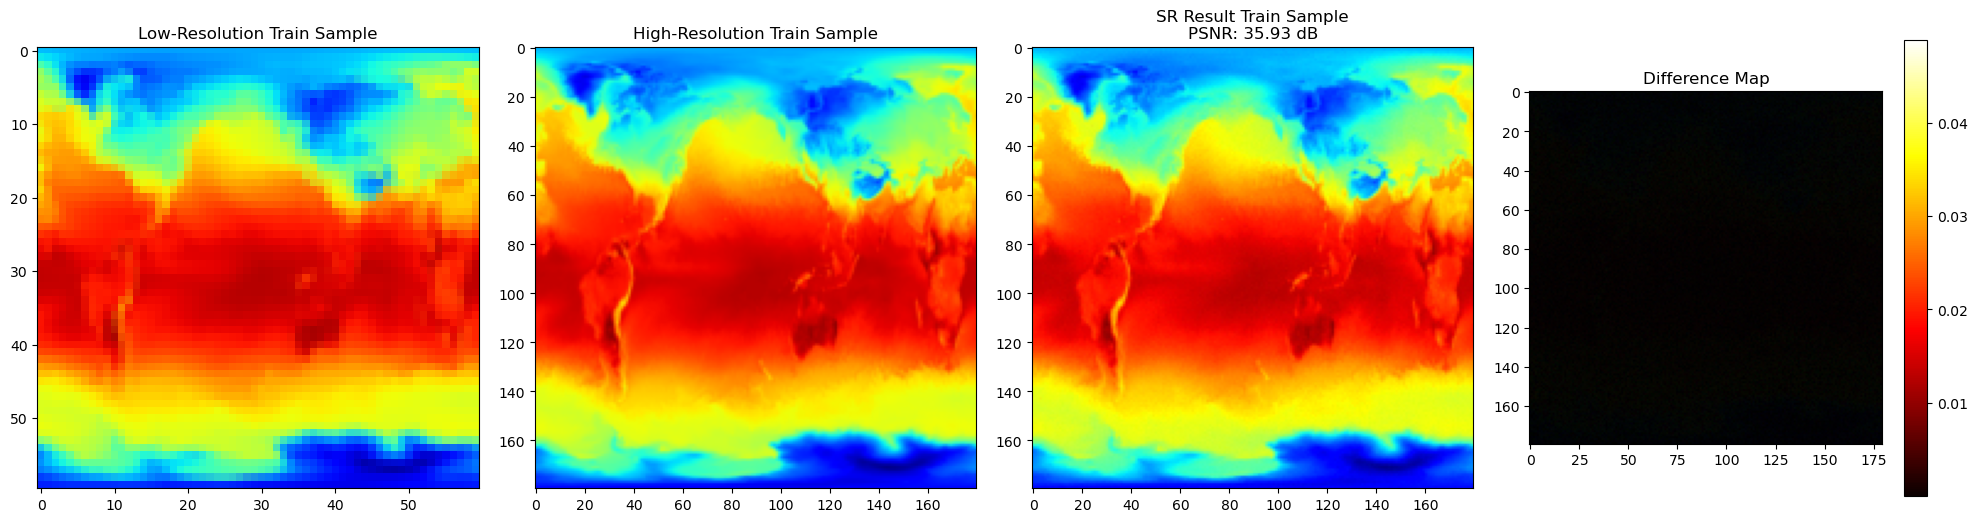

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


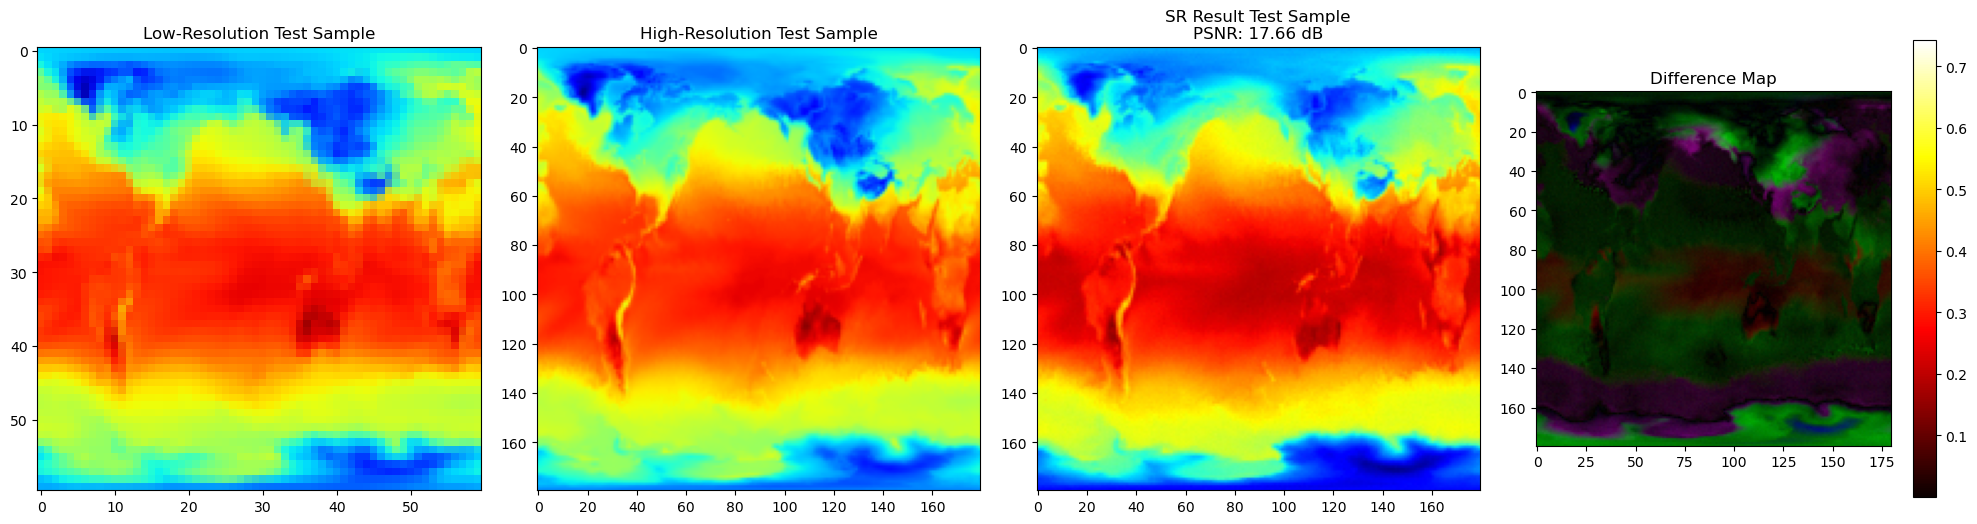

In [138]:
from   skimage.metrics        import peak_signal_noise_ratio as psnr
from   skimage.metrics        import structural_similarity   as ssim
from   skimage.metrics        import structural_similarity   as  ssim
from   torch.utils.data       import DataLoader, Dataset
from   PIL                    import Image
from   collections            import OrderedDict
from   datetime               import datetime
from   torch.utils.data       import DataLoader, random_split
import torch.nn               as     nn
import torch.optim            as     optim
import torchvision.transforms as     transforms
import numpy                  as     np
import matplotlib.pyplot      as     plt
import pandas                 as     pd
import torch.optim            as     optim
import os
import openpyxl
import torch
import torch.fft

# Define the Patch Embedding layer
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=100, patch_size=16, in_channels=3, embed_dim=256):
        super(PatchEmbedding, self).__init__()
        self.image_size  = image_size
        self.patch_size  = patch_size
        self.in_channels = in_channels
        self.embed_dim   = embed_dim
        self.num_patches = (image_size // patch_size) ** 2
        self.projection  = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == W == self.image_size, f"Input image size ({H}*{W}) does not match model image size ({self.image_size}*{self.image_size})"
        x = self.projection(x).reshape(B, self.num_patches, self.embed_dim)
        return x

# Define the SIREN components
def get_mgrid(sidelen, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid   = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid   = mgrid.reshape(-1, dim)
    return mgrid

class SineLayer(nn.Module):        
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=10):
        super().__init__()
        self.omega_0     = omega_0
        self.is_first    = is_first
        self.in_features = in_features
        self.linear      = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input):
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate

class FFTFilterLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, filter_type='low', cutoff=0.5):
        """
        FFT-based filter layer.
        Args:
            in_features: Number of input features.
            out_features: Number of output features.
            bias: Whether to include a bias term.
            filter_type: 'low' for low-pass, 'high' for high-pass filtering.
            cutoff: Fraction of frequencies to retain (e.g., 0.5 for 50%).
        """
        super().__init__()
        self.linear      = nn.Linear(in_features, out_features, bias=bias)
        self.filter_type = filter_type
        self.cutoff      = cutoff

    def forward(self, x):
        # Apply linear transformation
        x            = self.linear(x)
        x_fft        = torch.fft.fft(x, dim=-1)
        num_features = x.size(-1)
        cutoff_idx   = int(num_features * self.cutoff)
        mask         = torch.zeros_like(x_fft, dtype=torch.complex64)

        if self.filter_type   == 'low':
            mask[..., :cutoff_idx] = 1  # Keep low frequencies
        elif self.filter_type == 'high':
            mask[..., cutoff_idx:] = 1  # Keep high frequencies
        # Apply the mask
        # print(f'fft size is {x_fft.size()}')
        # print(f'mask size is {mask.size()}')
        
        x_filtered    = x_fft * mask
        # Perform inverse FFT
        x             = torch.fft.ifft(x_filtered, dim=-1).real
        return x

class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, filter_type='low', cutoff=5):
        """
        SIREN network with FFT-based activation function.
        """
        super().__init__()
        self.net = []
        self.net.append(FFTFilterLayer(in_features, hidden_features, filter_type=filter_type, cutoff=cutoff))
        for _ in range(hidden_layers):
            self.net.append(FFTFilterLayer(hidden_features, hidden_features, filter_type=filter_type, cutoff=cutoff))
        if outermost_linear:
            self.net.append(nn.Linear(hidden_features, out_features))
        else:
            self.net.append(FFTFilterLayer(hidden_features, out_features, filter_type=filter_type, cutoff=cutoff))
        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        return output, coords


# Define the custom TransformerEncoderLayer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, siren_hidden_features, siren_hidden_layers, filter_type='low', cutoff=5):
        super(TransformerEncoderLayer, self).__init__()
        self.cutoff      = cutoff
        self.filter_type = filter_type
        self.attention   = nn.MultiheadAttention(embed_dim, num_heads)
        self.siren       = Siren(embed_dim, siren_hidden_features, siren_hidden_layers, embed_dim, 
                                 outermost_linear=True,filter_type=filter_type, cutoff=cutoff)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.dropout     = nn.Dropout(0.1)

    def forward(self, x):
        # Self-attention
        x_res = x
        x, _  = self.attention(x, x, x)
        x     = self.dropout(x)
        x     = self.layer_norm1(x + x_res)
        
        # SIREN instead of Feedforward network
        x_res = x
        x, _  = self.siren(x)
        x     = self.dropout(x)
        x     = self.layer_norm2(x + x_res)
        
        return x


# Define the Vision Transformer model with SIREN
class VisionTransformerWithSiren(nn.Module):
    def __init__(self, image_size=100, patch_size=16, in_channels=3, embed_dim=256, 
                 num_heads=8, num_layers=1, siren_hidden_features=512, siren_hidden_layers=1,
                 filter_type='low',cutoff=20):
        super(VisionTransformerWithSiren, self).__init__()
        self.filter_type  = filter_type
        self.image_size   = image_size
        self.cutoff       = cutoff
        self.in_channels  = in_channels
        self.patch_size   = patch_size
        self.patch_embed  = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patch_embed.num_patches + 1, embed_dim))
        self.transformer_encoder_layers = nn.ModuleList([TransformerEncoderLayer(embed_dim, num_heads, embed_dim, 
                                                                                 siren_hidden_features, siren_hidden_layers, 
                                                                                 filter_type=filter_type, cutoff=cutoff) for _ in range(num_layers)])
        self.fc           = nn.Linear(self.patch_embed.num_patches * embed_dim, 2)  # Adjust the output size for the SIREN input
        self.siren        = Siren(in_features=2, hidden_features=512, hidden_layers=1, out_features=3 * (image_size * 3) ** 2, 
                                  outermost_linear=True,filter_type=filter_type, cutoff=cutoff)

    def forward(self, x):
        
        x       = self.patch_embed(x)
        B, N, _ = x.shape
        x       += self.pos_encoding[:, :N]
        for encoder_layer in self.transformer_encoder_layers:
            x = encoder_layer(x)
        x       = x.view(B, -1)
        x       = self.fc(x)  # Adjusted to match SIREN input size
        x, _    = self.siren(x)
        x       = x.view(B, 3, self.image_size * 3, self.image_size * 3)
        return x


# Define the dataset and data loader
class CustomDataset(Dataset):
    def __init__(self, low_res_images, high_res_images, transform=None):
        self.low_res_images  = low_res_images
        self.high_res_images = high_res_images
        self.transform       = transform

    def __len__(self):
        return len(self.low_res_images)

    def __getitem__(self, idx):
        low_res_img  = self.low_res_images[idx]
        high_res_img = self.high_res_images[idx]
        if self.transform:
            low_res_img  = self.transform(low_res_img)
            high_res_img = self.transform(high_res_img)
        return low_res_img, high_res_img

# Load and preprocess the data
def preprocess_image(image_path, image_size):
    img       = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])
    return transform(img)

def load_data_sisr(image_size=240,img_num=1):
    # Load low-resolution images
    low_res_images  = [preprocess_image(f"D:/data/Temp/1_{img_num}.png", image_size)]
    low_res_images  = torch.stack(low_res_images)
    
    high_res_images = [preprocess_image(f"D:/data/Temp/1_{img_num}_{img_num}.png", 3*image_size)]
    high_res_images = torch.stack(high_res_images)

    return low_res_images, high_res_images



def load_data_misrcategory(image_size=240, num_images=10):
    low_res_images  = []
    high_res_images = []
    for img_num in range(1, num_images + 1):
        # Load low-resolution images
        low_res_image  = preprocess_image(f"../data/Temp/simple_plotTS_1_{img_num}.png", image_size)
        low_res_images.append(low_res_image)
        
        # Load high-resolution images
        high_res_image = preprocess_image(f"../data/Temp/simple_plotTS_1_{img_num}.png", 3 * image_size)
        high_res_images.append(high_res_image)

    low_res_images  = torch.stack(low_res_images)
    high_res_images = torch.stack(high_res_images)
    return low_res_images, high_res_images


def load_data_all(image_size=240, low_res_folder="../data/1LR/Total", high_res_folder="../data/1HR/Total"):
    low_res_images = []
    high_res_images = []
    
    # List all low-resolution images
    low_res_files = sorted([f for f in os.listdir(low_res_folder) if f.endswith(".png")])
    high_res_files = sorted([f for f in os.listdir(high_res_folder) if f.endswith(".png")])
    
    assert len(low_res_files) == len(high_res_files), "Mismatch between low-resolution and high-resolution image counts."

    for low_res_file, high_res_file in zip(low_res_files, high_res_files):
        # Load low-resolution images
        low_res_image = preprocess_image(os.path.join(low_res_folder, low_res_file), image_size)
        low_res_images.append(low_res_image)
        
        # Load high-resolution images
        high_res_image = preprocess_image(os.path.join(high_res_folder, high_res_file), 3 * image_size)
        high_res_images.append(high_res_image)

    low_res_images = torch.stack(low_res_images)
    high_res_images = torch.stack(high_res_images)
    return low_res_images, high_res_images

    
def calculate_ssim(image1, image2):
    ssim_value = ssim(image1, image2, channel_axis=-1, data_range=1.0)
    return ssim_value

# Training and testing functions
def save_model(model, path):
    """Save the PyTorch model."""
    torch.save(model.state_dict(), path)


# Training and testing functions
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs, save_path='best_model.pth'):
    """Train the model and save the best one based on PSNR and MSE."""
    best_psnr = -float('inf')
    best_mse  = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for low_res, high_res in train_loader:
            optimizer.zero_grad()
            outputs     = model(low_res)
            loss        = criterion(outputs, high_res)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        # Evaluate on the test set
        model.eval()
        test_psnr, test_mse, PSNR = 0.0, 0.0, 0.0
        with torch.no_grad():
            for low_res, high_res in test_loader:
                outputs    = model(low_res)
                mse_value  = criterion(outputs, high_res).item()
                psnr_value = psnr(
                    high_res.cpu().numpy(),
                    outputs.cpu().numpy(),
                    data_range=1.0
                )
                # print(psnr_value)
                test_mse  += mse_value
                test_psnr += psnr_value
        
        test_mse  /= len(test_loader)
        test_psnr /= len(test_loader)
        
        if test_psnr  > best_psnr and test_mse < best_mse:
            best_psnr = test_psnr
            best_mse  = test_mse
            save_model(model, save_path)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train MSE: {test_mse:.4f}, Train PSNR: {test_psnr:.2f}, Best Train PSNR: {best_psnr:.2f}")
        
num_of_images     = 2
num_of_epoches    = 100
steps_til_summary = 1
Layer             = 3
LR_imagesize      = 60

# Assume `num_of_images` is the total number of images to load
# low_res_images, high_res_images = load_data_all(image_size=100)
low_res_images, high_res_images = load_data_misrcategory(image_size=LR_imagesize,num_images=num_of_images)
dataset                         = CustomDataset(low_res_images, high_res_images)
train_size                      = int(0.8 * len(dataset))
# dataset = CustomDataset(low_res_images, high_res_images)
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)  # Adjust batch size as needed
test_size                       = len(dataset) - train_size
train_dataset, test_dataset     = random_split(dataset, [train_size, test_size])

train_loader                    = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader                     = DataLoader(test_dataset, batch_size=8, shuffle=False)


start_time = datetime.now()
model      = VisionTransformerWithSiren(
    image_size          = LR_imagesize,
    patch_size          = 20,
    in_channels         = 3,
    siren_hidden_layers = 5,
    embed_dim           = 128,
    num_heads           = 8,
    num_layers          = 2,
    filter_type         = 'low',
    cutoff              = 1
)

criterion  = nn.MSELoss()
optimizer  = optim.Adam(model.parameters(), lr=1e-4)

best_model_path = "best_model.pth"
train_and_evaluate(model,
                   train_loader,
                   test_loader,
                   criterion,
                   optimizer,
                   epochs    = num_of_epoches,
                   save_path = best_model_path
                  )

end_time        = datetime.now()
elapsed_time    = end_time - start_time
print(f"Elapsed time is: {elapsed_time}")

def visualize_sample(model, dataloader, sample_idx=0, title=""):
    """Visualize a single sample's SR result and the difference with the ground truth."""
    model.eval()
    with torch.no_grad():
        # Retrieve a sample from the dataloader
        low_res, high_res = next(iter(dataloader))
        low_res_sample = low_res[sample_idx].unsqueeze(0)  # Add batch dimension
        high_res_sample = high_res[sample_idx]
        sr_result = model(low_res_sample).squeeze(0)  # Remove batch dimension

        # Convert tensors to numpy for visualization
        low_res_np = low_res_sample.squeeze(0).permute(1, 2, 0).cpu().numpy()
        high_res_np = high_res_sample.permute(1, 2, 0).cpu().numpy()
        sr_result_np = sr_result.permute(1, 2, 0).cpu().numpy()
        
        # Compute the absolute difference for visualization
        diff_np = abs(high_res_np - sr_result_np)

        # Compute PSNR
        psnr_value = psnr(
            high_res_sample.cpu().numpy(),
            sr_result.cpu().numpy(),
            data_range=1.0
        )

        # Plot
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(low_res_np)
        plt.title(f"Low-Resolution {title}")

        plt.subplot(1, 4, 2)
        plt.imshow(high_res_np)
        plt.title(f"High-Resolution {title}")

        plt.subplot(1, 4, 3)
        plt.imshow(sr_result_np)
        plt.title(f"SR Result {title}\nPSNR: {psnr_value:.2f} dB")

        plt.subplot(1, 4, 4)
        plt.imshow(diff_np)
        plt.colorbar()
        plt.title("Difference Map")

        plt.tight_layout()
        plt.savefig(f"{title}.png")
        plt.show()

# Visualize samples
model.load_state_dict(torch.load(best_model_path))
visualize_sample(model, train_loader, sample_idx=0, title="Train Sample")
visualize_sample(model, test_loader, sample_idx=0, title="Test Sample")


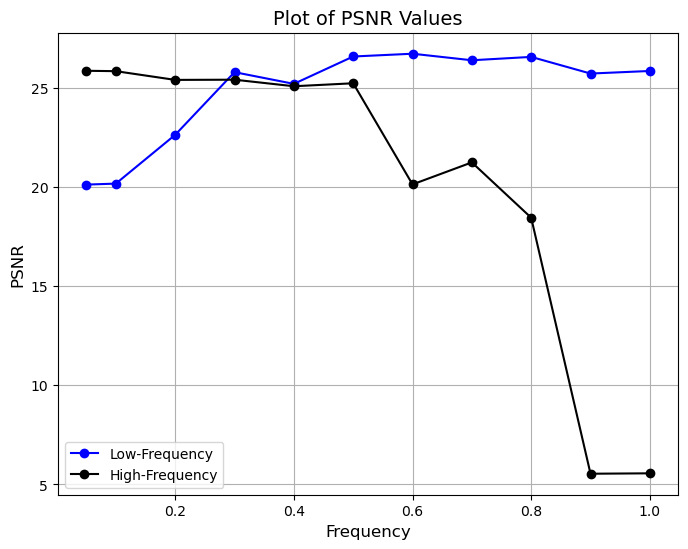

In [133]:
x = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8, 0.9,1]
y1 = [20.12,20.17,22.63,25.79,25.20,26.58,26.72,26.39,26.56,25.72,25.85]
y2 = [25.86,25.84,25.40,25.41,25.08,25.23,20.13,21.24,18.45,5.54,5.56]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y1, marker='o', linestyle='-', color='b', label='Low-Frequency')
plt.plot(x, y2, marker='o', linestyle='-', color='k', label='High-Frequency')

# Add labels, title, and legend
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('PSNR', fontsize=12)
plt.title('Plot of PSNR Values', fontsize=14)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


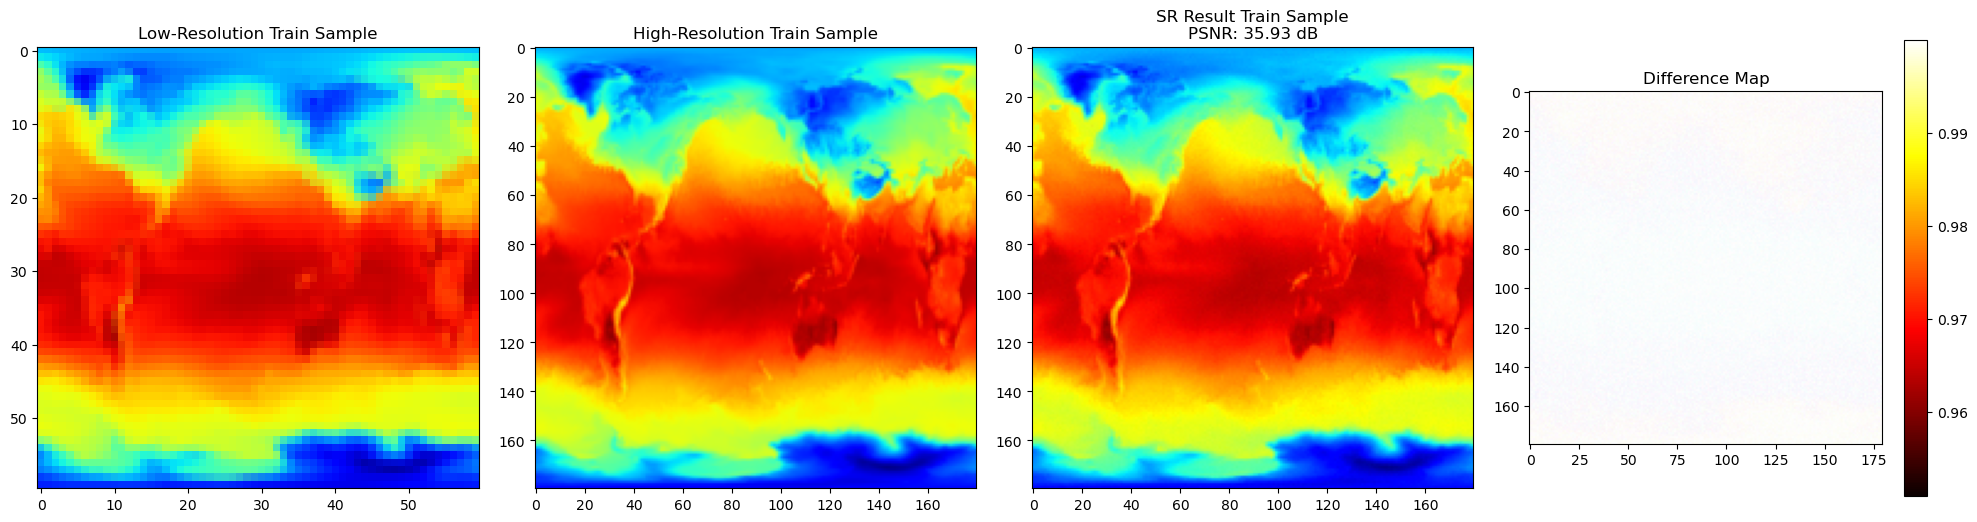

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


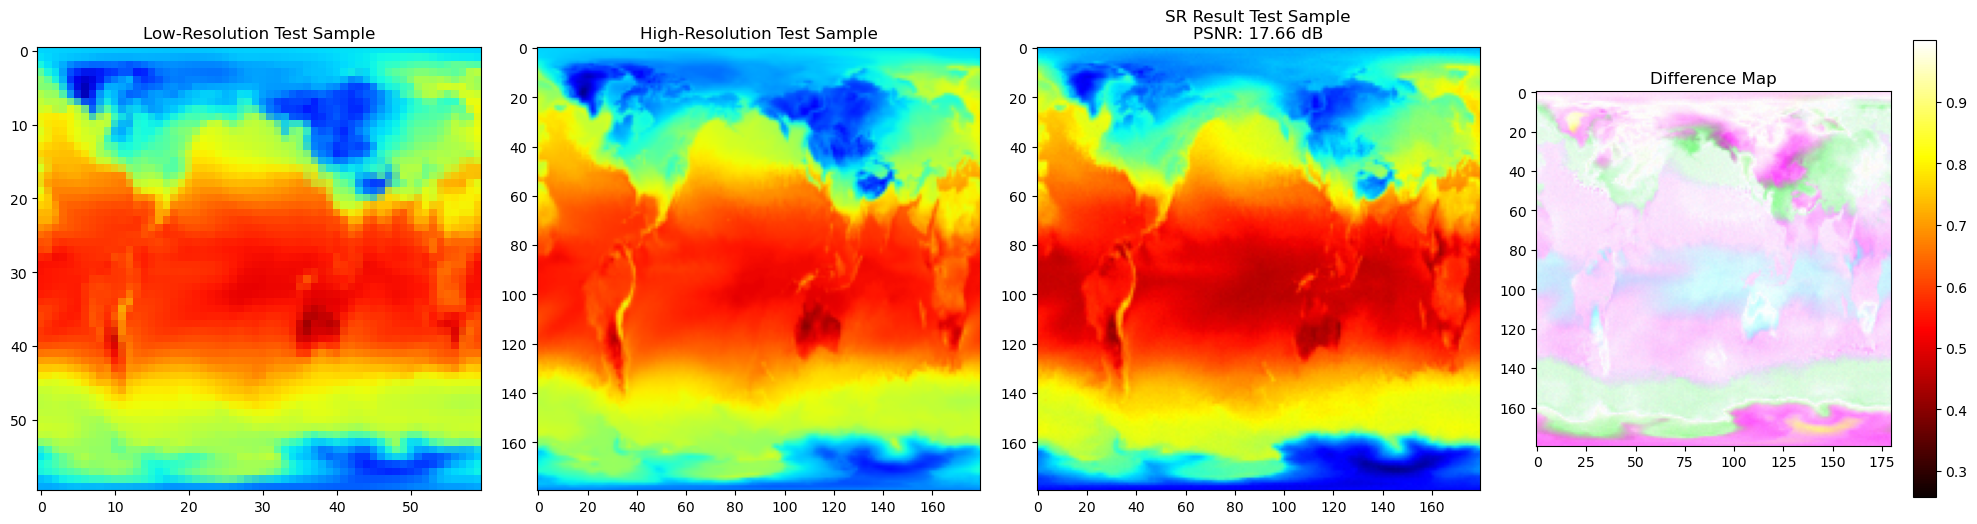

In [145]:
def visualize_sample(model, dataloader, sample_idx=0, title=""):
    """Visualize a single sample's SR result and the difference with the ground truth."""
    model.eval()
    with torch.no_grad():
        # Retrieve a sample from the dataloader
        low_res, high_res = next(iter(dataloader))
        low_res_sample = low_res[sample_idx].unsqueeze(0)  # Add batch dimension
        high_res_sample = high_res[sample_idx]
        sr_result = model(low_res_sample).squeeze(0)  # Remove batch dimension

        # Convert tensors to numpy for visualization
        low_res_np = low_res_sample.squeeze(0).permute(1, 2, 0).cpu().numpy()
        high_res_np = high_res_sample.permute(1, 2, 0).cpu().numpy()
        sr_result_np = sr_result.permute(1, 2, 0).cpu().numpy()
        
        # Compute the absolute difference for visualization
        diff_np = abs(high_res_np - sr_result_np)

        # Compute PSNR
        psnr_value = psnr(
            high_res_sample.cpu().numpy(),
            sr_result.cpu().numpy(),
            data_range=1.0
        )

        # Plot
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(low_res_np)
        plt.title(f"Low-Resolution {title}")

        plt.subplot(1, 4, 2)
        plt.imshow(high_res_np)
        plt.title(f"High-Resolution {title}")

        plt.subplot(1, 4, 3)
        plt.imshow(sr_result_np)
        plt.title(f"SR Result {title}\nPSNR: {psnr_value:.2f} dB")

        plt.subplot(1, 4, 4)
        plt.imshow(1-diff_np,cmap='hot')
        plt.colorbar()
        plt.title("Difference Map")

        plt.tight_layout()
        plt.savefig(f"{title}.png")
        plt.show()

# Visualize samples
model.load_state_dict(torch.load(best_model_path))
visualize_sample(model, train_loader, sample_idx=0, title="Train Sample")
visualize_sample(model, test_loader, sample_idx=0, title="Test Sample")